In [17]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
to_mmddyyyyHHMM = lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")
climate_data = pd.read_csv('climate_15min_int_data.csv',index_col=0,converters={'datetime':to_mmddyyyyHHMM})

<h3>Generate features to distinguish the data on hour and minutes basis</h3>
<h3>Shuffle the data, as we are going to try Gradient boosting technique for training the model</h3>

In [18]:
climate_data['hour']=climate_data.datetime.dt.hour
climate_data['min']=climate_data.datetime.dt.minute
climate_data_shuffled=climate_data.sample(frac=1).reset_index(drop=True)

<h3>Random forest while spliting the data calculates the importance or relevance of dependent variables towards the prediting variable and rates them as per their importance</h3>
<h3> We will use this feature of random forest as feature selection technique and select the most important feature for fitting models</h3>

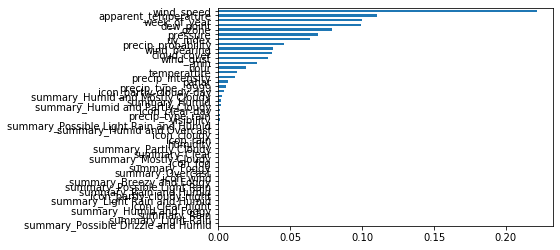

In [24]:
y=climate_data_shuffled['power']
X=climate_data_shuffled.drop(['power','datetime'],axis=1)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rfr=RandomForestRegressor(n_estimators=100)
rfr.fit(X,y)
import matplotlib.pyplot as plt
feat_importances = pd.Series(rfr.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

<h3>Select Most Important features from the data</h3>

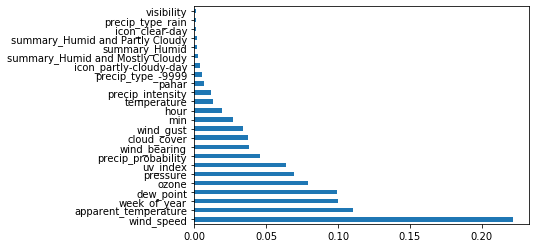

In [28]:
feat_importances.nlargest(24).plot(kind='barh')

In [29]:
climate_data_featured=climate_data_shuffled[feat_importances.sort_values(ascending=False)[:24].index.to_list()+['power','datetime']]

<h3>Split the data in Test and Train set</h3>

In [30]:
y=climate_data_featured['power']
X=climate_data_featured.drop(['power','datetime'],axis=1)

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.25,random_state=0)

<h3> Grid search for finding the best parameters for the GBR.</h3>
<h3> But due to having low config machine i am not able to tune all the features</h3>

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import regression
param_grid = {#'loss':['ls', 'lad', 'huber', 'quantile'],
                  'max_depth': [3,4], 
                  #'min_samples_split': [2,4,6,8],
                  #'min_samples_leaf':[2,4,6,8],
                  'n_estimators':[150,175,200],
                  'learning_rate':[round(x,3) for x in np.arange(0.01,0.5,0.05)]
                 }
grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=3,verbose=1,n_jobs=2)
grid_search.fit(X, y)
y_true, y_pred = y, grid_search.predict(X)
regression.mean_squared_error(y_true, y_pred)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed: 16.9min finished


9135.410610718556

In [64]:
# grid_search.cv_results_
# grid_search.best_score_
grid_search.best_params_

{'learning_rate': 0.21, 'max_depth': 4, 'n_estimators': 175}

<h3>Apply Gradient Boosting Regressor with different learning Rate to train the model on the data and select the best learning rate</h3>

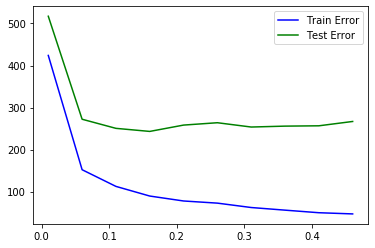

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

lr_list = [x for x in np.arange(0.01,0.5,0.05)]
plt_data={'learning_rate':[],'lin_rmse_train':[],'lin_rmse_test':[]}
for learning_rate in lr_list:
    gbmr = GradientBoostingRegressor(n_estimators=175, learning_rate=learning_rate, random_state=0,max_depth=4)
    gbmr.fit(xtrain, ytrain)
    pred_train=gbmr.predict(xtrain)
    pred_test=gbmr.predict(xtest)
    plt_data['learning_rate'].append(learning_rate)
    plt_data['lin_rmse_train'].append(np.sqrt(mean_squared_error(ytrain,pred_train)))
    plt_data['lin_rmse_test'].append(np.sqrt(mean_squared_error(ytest,pred_test)))
plt_data=pd.DataFrame(plt_data)
plt.plot(plt_data.learning_rate,plt_data.lin_rmse_train,'blue',label='Train Error')
plt.plot(plt_data.learning_rate,plt_data.lin_rmse_test,'green',label='Test Error')
plt.legend()

<h3>Looking at the plot we can see that some where between 0.3 and 0.4 test error start increasing while train error is keeps on decreasing, so we can choose learning rate between this value.</h3>

In [123]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
gbr=GradientBoostingRegressor(n_estimators=175, learning_rate=0.21,random_state=0,max_depth=4,min_samples_split=100)
gbr.fit(xtrain,ytrain)
pred_train=gbr.predict(xtrain)
pred_test=gbr.predict(xtest)
lin_rmse_train = np.sqrt(mean_squared_error(ytrain,pred_train))
lin_rmse_test=np.sqrt(mean_squared_error(ytest,pred_test))
print("Train Error",lin_rmse_train,"Test Error",lin_rmse_test)

Train Error 156.12428115665003 Test Error 262.13128953380277


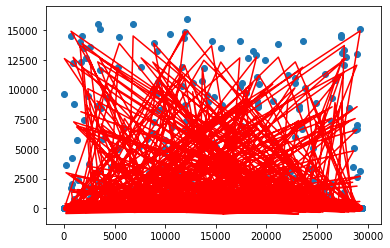

In [220]:
plt.plot(ytrain.index,pred_train,'red')
plt.scatter(ytrain.index,ytrain)

<h3> Read the Weather forecast file preprocess it and predicted the value</h3>
<h4> We can create a class and use the methods in class to automate this</h4>

In [188]:
to_mmddyyyyHHMM = lambda dt: datetime.strptime(dt, "%m/%d/%Y %H:%M")
df_wether_forecast=pd.read_csv('weather_forecast.csv',index_col=0,converters={'datetime_utc':to_mmddyyyyHHMM,'datetime_local':to_mmddyyyyHHMM,'sunrise':to_mmddyyyyHHMM,'sunset':to_mmddyyyyHHMM,'updated_at':to_mmddyyyyHHMM})

In [189]:
df_wether_forecast=df_wether_forecast[(df_wether_forecast.datetime_local.dt.hour>=6) & (df_wether_forecast.datetime_local.dt.hour<=18)]
df_wether_forecast.drop(['wind_chill','heat_index','qpf','snow','pop','fctcode','precip_accumulation'],axis=1,inplace=True)
df_wether_forecast.fillna('-9999',inplace=True)
df_wether_forecast.sort_values('datetime_local',inplace=True)

In [190]:
def get_pahar(hr):
    """ We will give more weight to afternoon hours as during this time solar heat and radiation is more.
    Resulting in more generation of solar power"""
    if (hr>=6 and hr<9): return(4)    #Sunrise time
    elif hr>=9 and hr<12: return(3)   #Morning Time
    elif hr>=12 and hr<15: return(1)  #Afternoon
    elif hr>=15 and hr<=18: return(2) #Evening

In [191]:
df_wether_forecast=pd.concat([df_wether_forecast,pd.get_dummies(df_wether_forecast.precip_type,prefix='precip_type')],axis=1)
df_wether_forecast=pd.concat([df_wether_forecast,pd.get_dummies(df_wether_forecast.summary,prefix='summary')],axis=1)
df_wether_forecast=pd.concat([df_wether_forecast,pd.get_dummies(df_wether_forecast.icon,prefix='icon')],axis=1)
df_wether_forecast['week_of_year']=df_wether_forecast.datetime_local.dt.weekofyear
df_wether_forecast['pahar']=df_wether_forecast.datetime_local.dt.hour.apply(lambda hr: get_pahar(hr))
df_wether_forecast.drop(['icon','plant_id','summary','sunrise','sunset','updated_at','precip_type','datetime_utc'],axis=1,inplace=True)

In [192]:
from datetime import datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt for dt in 
       datetime_range(df_wether_forecast.datetime_local.min(), df_wether_forecast.datetime_local.max(), 
       timedelta(minutes=15))]

In [193]:
pred_data=pd.DataFrame(dts,columns=['datetime'])
pred_data['Date']=pred_data['datetime'].dt.strftime('%Y-%m-%d %HH')
df_wether_forecast['Date']=df_wether_forecast.datetime_local.dt.strftime('%Y-%m-%d %HH')
pred_data=pred_data.join(df_wether_forecast.set_index('Date'),on=['Date'],how='inner').drop(['Date','datetime_local'],axis=1)
pred_data['hour']=pred_data.datetime.dt.hour
pred_data['min']=pred_data.datetime.dt.minute
for missing_col in [x for x in climate_data.columns if not pred_data.columns.contains(x)]:
    pred_data[missing_col]=0

In [198]:
pred_data['power']=gbr.predict(pred_data[feat_importances.sort_values(ascending=False)[:24].index.to_list()])
pred_data[['datetime','power']].to_csv('power_forecast.csv')